In [3]:
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xarrayMannKendall import *

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:35995 Dashboard: /proxy/37169/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [4]:
keys = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']

In [5]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

Load CMIP6 individual models

In [6]:
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_names = list(uas_cmip.keys())

Load region mask

In [7]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

Calculate area for weighting

In [8]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['ERA-Interim']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['ERA-Interim'].isel(time = 0)))
for i in range(len(uas['ERA-Interim']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['ERA-Interim']['lat'], 'lon':uas['ERA-Interim']['lon']})

In [9]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_names:
    u_ave[k] = (uas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [10]:
u_ave_xarray = u_ave[keys[0]]
v_ave_xarray = v_ave[keys[0]]
for k in keys[1:]+model_names:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = keys+model_names
v_ave_xarray['model'] = keys+model_names

In [11]:
uas_cmip_proj = {}; vas_cmip_proj = {}
uas_cmip_proj['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-2015_2100-ssp85.nc')['uas']
vas_cmip_proj['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-2015_2100-ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_cmip_proj[model_name] = xr.open_dataset(path_uas[i])['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_cmip_proj[model_name] = xr.open_dataset(path_vas[i])['vas']
model_names = list(uas_cmip_proj.keys())

In [12]:
u_ave_proj = {}
v_ave_proj = {}
for k in model_names:
    u_ave_proj[k] = (uas_cmip_proj[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_proj[k] = (vas_cmip_proj[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [13]:
u_ave_xarray_proj = u_ave_proj['CMIP6']
v_ave_xarray_proj = v_ave_proj['CMIP6']
for k in model_names[1:]:
    u_ave_xarray_proj = xr.concat([u_ave_xarray_proj, u_ave_proj[k]], dim = 'model')
    v_ave_xarray_proj = xr.concat([v_ave_xarray_proj, v_ave_proj[k]], dim = 'model')
u_ave_xarray_proj['model'] = model_names
v_ave_xarray_proj['model'] = model_names

In [14]:
u_sd_h = u_ave_xarray.sel(model = model_names[1:]).std('model')
v_sd_h = v_ave_xarray.sel(model = model_names[1:]).std('model')
u_sd_p = u_ave_xarray_proj.sel(model = model_names[1:]).std('model')
v_sd_p = v_ave_xarray_proj.sel(model = model_names[1:]).std('model')

In [15]:
u_cmip_complete = xr.concat([u_ave_xarray.sel(model = 'CMIP6'), u_ave_xarray_proj.sel(model = 'CMIP6')], dim = 'year')
v_cmip_complete = xr.concat([v_ave_xarray.sel(model = 'CMIP6'), v_ave_xarray_proj.sel(model = 'CMIP6')], dim = 'year')
usd_cmip_complete = xr.concat([u_sd_h, u_sd_p], dim = 'year')
vsd_cmip_complete = xr.concat([v_sd_h, v_sd_p], dim = 'year')

In [16]:
from palettable.tableau import Tableau_10

In [17]:
u_ave_xarray['model'][1:].values

array(['ERA5', 'CFSR', 'JRA55', 'CMIP6', 'INM-CM4-8', 'MRI-ESM2-0',
       'NESM3', 'IITM-ESM', 'INM-CM5-0', 'KACE-1-0-G', 'MPI-ESM1-2-HR',
       'GFDL-CM4', 'MIROC6', 'EC-Earth3-Veg-LR', 'MPI-ESM1-2-LR',
       'EC-Earth3-CC', 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'AWI-CM-1-1-MR',
       'GFDL-ESM4', 'BCC-CSM2-MR', 'EC-Earth3', 'FGOALS-f3-L', 'CanESM5'],
      dtype='<U16')

In [18]:
from matplotlib.lines import Line2D

In [19]:
legend_elements = [Line2D([0], [0], color = 'r', lw = 2, label = 'Multireanalysis mean'),
                   Line2D([0], [0], color = 'k', lw = 2, label = 'CMIP6'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[0], lw = .8, label = 'ERA-Interim'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[1], lw = .8, label = 'ERA5'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[2], lw = .8, label = 'CFSR'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[4], lw = .8, label = 'JRA55')]

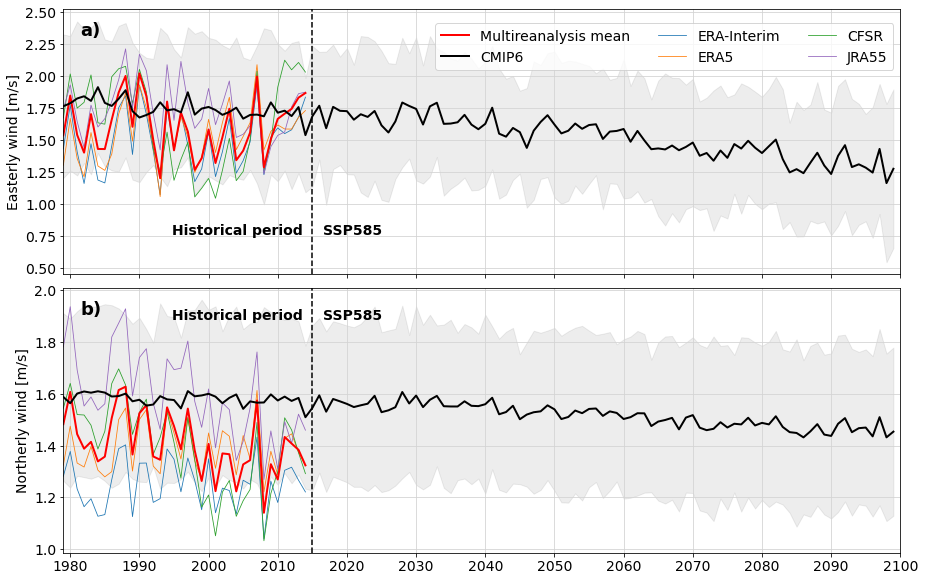

In [121]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15,10))
gr = gs.GridSpec(2, 1, figure = fig, hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0])]
for ax, label in zip(axs, ['a)', 'b)']):
    ax.text(0.02, .9, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.set_xticks(np.arange(1980, 2110, 10))
    if ax == axs[0]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(np.arange(1980, 2110, 10))
    ax.set_xlim(1979, 2100)
        
for k, cl in zip(keys[:-1], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    axs[0].plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = k), color = cl, linewidth = .8, label = k)
    axs[1].plot(v_ave_xarray['year'], v_ave_xarray.sel(model = k), color = cl, linewidth = .8, label = k)
axs[0].plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
axs[0].plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[0].fill_between(u_cmip_complete['year'], -u_cmip_complete+usd_cmip_complete, -u_cmip_complete-usd_cmip_complete, color = 'k', alpha = 0.07)
axs[0].set_ylabel('Easterly wind [m/s]')
axs[1].plot(v_ave_xarray['year'], v_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
axs[1].plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[1].fill_between(v_cmip_complete['year'], v_cmip_complete-vsd_cmip_complete, v_cmip_complete+vsd_cmip_complete, color = 'k', alpha = 0.07)
axs[1].set_ylabel('Northerly wind [m/s]')
axs[0].axvline(x = 2015, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015, linestyle = '--', color = 'k')

axs[0].text(0.13, .15, 'Historical period', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[0].text(0.31, .15, 'SSP585', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[1].text(0.13, .88, 'Historical period', transform = axs[1].transAxes, size = 14, weight = 'bold')
axs[1].text(0.31, .88, 'SSP585', transform = axs[1].transAxes, size = 14, weight = 'bold')

fig.legend(handles = legend_elements, ncol = 3, bbox_to_anchor = (0.9, 0.87))

plt.savefig('../results/v4/fig4.pdf', bbox_inches = 'tight')

In [16]:
u_ave_cmip = {}
v_ave_cmip = {}
for k in u_ave_xarray_proj['model'][1:].values:
    u_ave_cmip[k] = xr.concat([u_ave_xarray.sel(model = k), u_ave_xarray_proj.sel(model = k)], dim = 'year')
    v_ave_cmip[k] = xr.concat([v_ave_xarray.sel(model = k), v_ave_xarray_proj.sel(model = k)], dim = 'year')

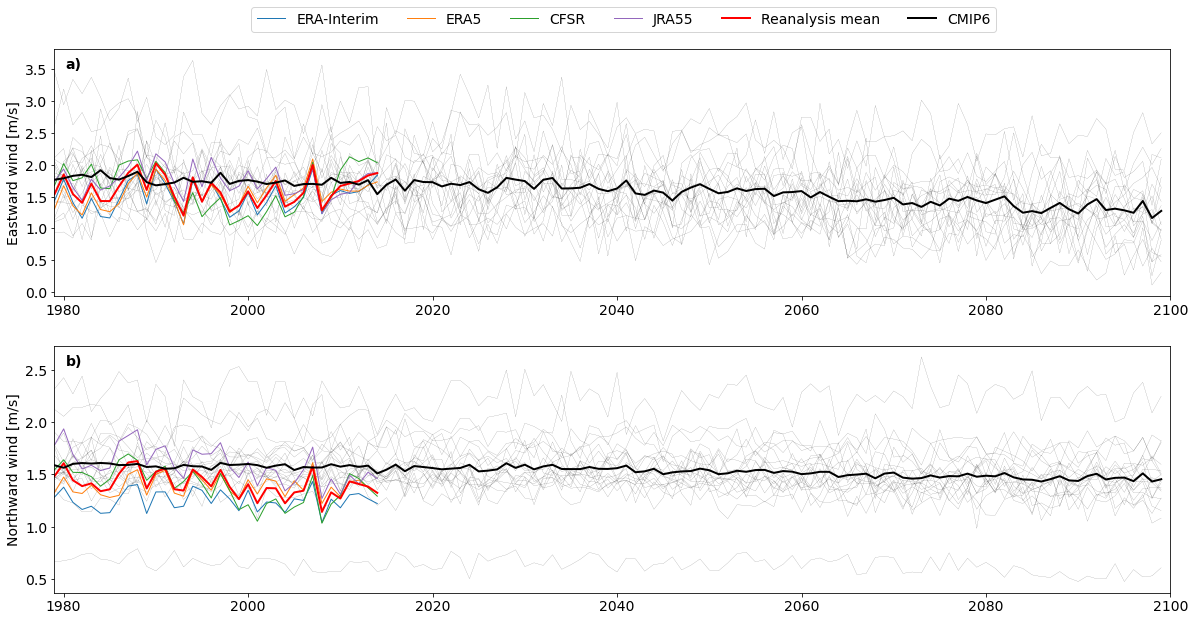

In [24]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.set_xlim(1979, 2100)
#fig.subplots_adjust(hspace = 0.01)
ax1.text(0.01, .92, 'a)', transform = ax1.transAxes, size = 14, weight = 'bold')
ax2.text(0.01, .92, 'b)', transform = ax2.transAxes, size = 14, weight = 'bold')
for k in u_ave_xarray_proj['model'][1:].values:
    ax1.plot(u_ave_cmip[k]['year'], -u_ave_cmip[k], color = 'k', linewidth = .1)
    ax2.plot(v_ave_cmip[k]['year'], v_ave_cmip[k], color = 'k', linewidth = .1)
for k, cl in zip(keys[:-1], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    ax1.plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = k), color = cl, linewidth = 1, label = k)
    ax2.plot(v_ave_xarray['year'], v_ave_xarray.sel(model = k), color = cl, linewidth = 1, label = k)
ax1.plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax1.plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
ax1.set_ylabel('Eastward wind [m/s]')
ax1.legend(ncol = 6, bbox_to_anchor = (.85, 1.2))
ax2.plot(v_ave_xarray['year'], v_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax2.plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
ax2.set_ylabel('Northward wind [m/s]')

plt.savefig('../results/v3/fig4-spaguetti.jpg', bbox_inches = 'tight')

# Quantify trends

In [20]:
u_concatenated = xr.concat([u_ave_xarray, u_ave_xarray_proj], dim = 'year')

In [49]:
u_concatenated = xr.concat([u_concatenated.drop('height').drop('plev'), u_ave_xarray.sel(model = keys[:-1]).mean('model').drop('plev').expand_dims('model')], dim = 'model')

In [51]:
MK_class = Mann_Kendall_test(-u_concatenated, 'time', coords_name = {'year':'time', 'model':'x'})
kk = MK_class.compute()

In [52]:
v_concatenated = xr.concat([v_ave_xarray, v_ave_xarray_proj], dim = 'year')

In [53]:
v_concatenated = xr.concat([v_concatenated.drop('height').drop('plev'), v_ave_xarray.sel(model = keys[:-1]).mean('model').drop('plev').expand_dims('model')], dim = 'model')

In [54]:
MK_class = Mann_Kendall_test(v_concatenated, 'time', coords_name = {'year':'time', 'model':'x'})
kk1 = MK_class.compute()

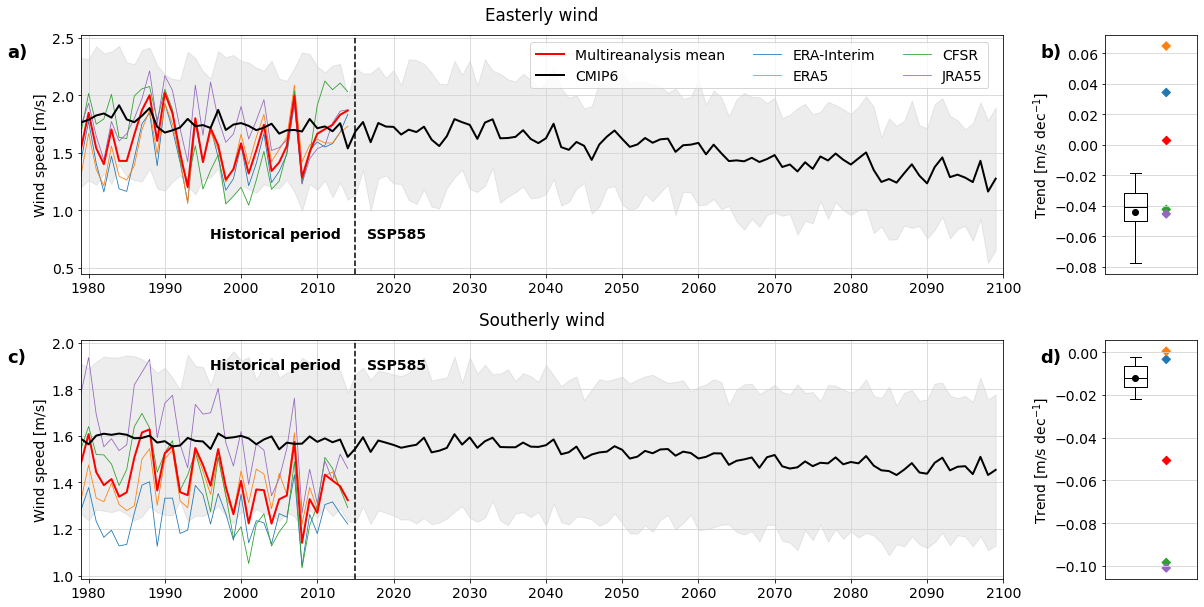

In [63]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, hspace = 0.28, width_ratios = [1, .1])
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['a)', 'c)', 'b)', 'd)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.08, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xticks(np.arange(1980, 2110, 10))
        ax.set_xlim(1979, 2100)
    else:
        ax.text(-0.7, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xlim(0.8, 1.4)
        
for k, cl in zip(keys[:-1], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    axs[0].plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = k), color = cl, linewidth = .8, label = k)
    axs[1].plot(v_ave_xarray['year'], v_ave_xarray.sel(model = k), color = cl, linewidth = .8, label = k)
axs[0].plot(u_ave_xarray['year'], -u_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
axs[0].plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[0].fill_between(u_cmip_complete['year'], -u_cmip_complete+usd_cmip_complete, -u_cmip_complete-usd_cmip_complete, color = 'k', alpha = 0.07)
axs[1].plot(v_ave_xarray['year'], v_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
axs[1].plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[1].fill_between(v_cmip_complete['year'], v_cmip_complete-vsd_cmip_complete, v_cmip_complete+vsd_cmip_complete, color = 'k', alpha = 0.07)

axs[0].set_title('Easterly wind', pad = 15)
axs[0].set_ylabel('Wind speed [m/s]')
axs[1].set_title('Southerly wind', pad = 15)
axs[1].set_ylabel('Wind speed [m/s]')
axs[0].axvline(x = 2015, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015, linestyle = '--', color = 'k')
axs[0].text(0.14, .15, 'Historical period', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[0].text(0.31, .15, 'SSP585', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[1].text(0.14, .88, 'Historical period', transform = axs[1].transAxes, size = 14, weight = 'bold')
axs[1].text(0.31, .88, 'SSP585', transform = axs[1].transAxes, size = 14, weight = 'bold')

axs[2].boxplot(kk['trend'].drop_sel(x=0).drop_sel(x = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6'])*10,
               showfliers = False, medianprops=dict(color='k'))
axs[2].scatter(np.ones(1), kk['trend'].sel(x = ['CMIP6'])*10, c = 'k')
axs[2].scatter(np.ones(1)+.2, kk['trend'].sel(x = 0)*10, c = 'r', marker = 'D')
axs[2].scatter(np.ones(4)+.2, kk['trend'].sel(x = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55'])*10,
               c = [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]],
               marker = 'D')
axs[3].boxplot(kk1['trend'].drop_sel(x=0).drop_sel(x = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6'])*10,
               showfliers = False, medianprops=dict(color='k'))
axs[3].scatter(np.ones(1), kk1['trend'].sel(x = ['CMIP6'])*10, c = 'k')
axs[3].scatter(np.ones(1)+.2, kk1['trend'].sel(x = 0)*10, c = 'r', marker = 'D')
axs[3].scatter(np.ones(4)+.2, kk1['trend'].sel(x = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55'])*10,
               c = [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]],
               marker = 'D')

axs[2].set_xticks([])
axs[2].set_xticklabels([])
axs[3].set_xticks([])
axs[3].set_xticklabels([])
axs[2].set_ylabel('Trend [m/s dec$^{-1}$]')
axs[3].set_ylabel('Trend [m/s dec$^{-1}$]')

fig.legend(handles = legend_elements, ncol = 3, bbox_to_anchor = (0.76, 0.88))

plt.savefig('../results/v4/fig4.jpg', bbox_inches = 'tight')

In [197]:
v_concatenated.sel(model = 'CMIP6').sel(year = slice(2005, 2015)).mean()

<xarray.DataArray ()>
array(1.56495265)
Coordinates:
    model    <U16 'CMIP6'
    plev     float64 ...

In [198]:
v_concatenated.sel(model = 'CMIP6').sel(year = slice(2090, 2100)).mean()

<xarray.DataArray ()>
array(1.46453942)
Coordinates:
    model    <U16 'CMIP6'
    plev     float64 1e+05

In [185]:
for k in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']:
    print(kk.sel(x=k)['trend']*10)

<xarray.DataArray 'trend' ()>
array(0.03430658)
Coordinates:
    x        <U16 'ERA-Interim'
<xarray.DataArray 'trend' ()>
array(0.06480676)
Coordinates:
    x        <U16 'ERA5'
<xarray.DataArray 'trend' ()>
array(-0.04252998)
Coordinates:
    x        <U16 'CFSR'
<xarray.DataArray 'trend' ()>
array(-0.04548379)
Coordinates:
    x        <U16 'JRA55'
<xarray.DataArray 'trend' ()>
array(-0.04400837)
Coordinates:
    x        <U16 'CMIP6'


In [186]:
for k in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']:
    print(kk1.sel(x=k)['trend']*10)

<xarray.DataArray 'trend' ()>
array(-0.00338158)
Coordinates:
    x        <U16 'ERA-Interim'
<xarray.DataArray 'trend' ()>
array(0.0004127)
Coordinates:
    x        <U16 'ERA5'
<xarray.DataArray 'trend' ()>
array(-0.09844947)
Coordinates:
    x        <U16 'CFSR'
<xarray.DataArray 'trend' ()>
array(-0.10099896)
Coordinates:
    x        <U16 'JRA55'
<xarray.DataArray 'trend' ()>
array(-0.0122573)
Coordinates:
    x        <U16 'CMIP6'
